# Publication references by researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications authored by a particular researcher, using his/her ORCID ID.

In [117]:
# Prepare the R graphql client.

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [118]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications with DataCite DOIs linked to that ORCID account.

query <- '{
   researcher(id: "https://orcid.org/0000-0003-1419-2405") {
    id
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        relatedIdentifiers {
          relatedIdentifier
        }
      }
    }
  }
}'

In [119]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [120]:
# Get the name of the researcher with ORCID ID https://orcid.org/0000-0003-1419-2405

display_markdown(data$data$researcher$name)

Martin Fenner

In [121]:
# Get the number of publications

display_json(data$data$researcher$publications$totalCount)

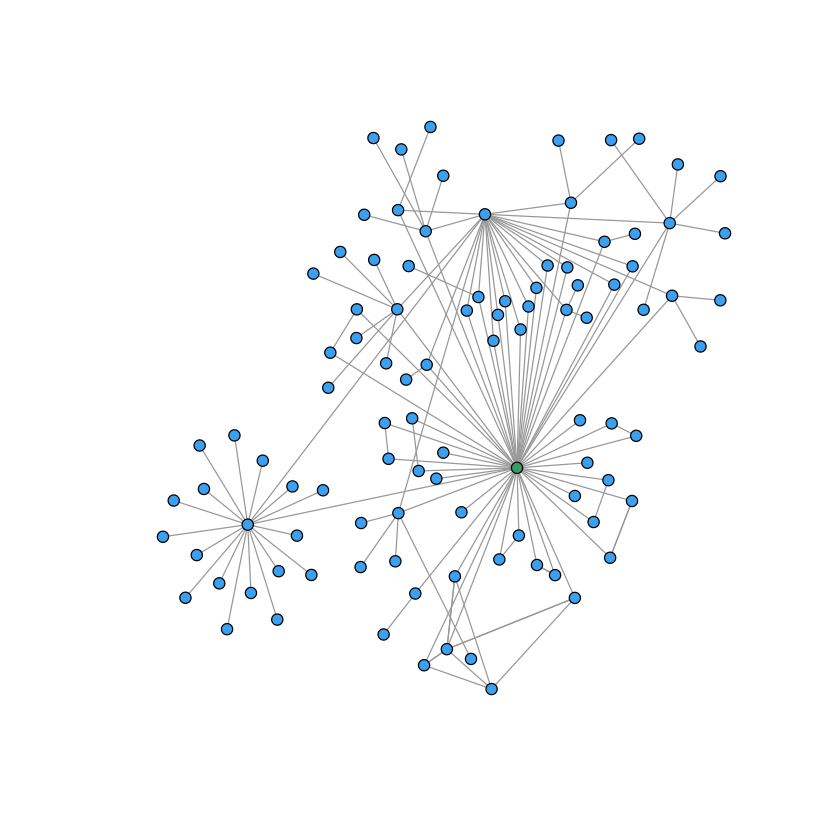

In [122]:
# generate data frame for nodes
researchers <- data.frame(id=data$data$researcher$id, pid_type=c('researcher'))
publications <- data.frame(id=data$data$researcher$publications$nodes$id, pid_type=c('publication'))
references <- data.frame(id=bind_rows(data$data$researcher$publications$nodes$relatedIdentifiers)[,1], pid_type=c('publication'))
nodes <- unique(rbind(researchers, publications, references))

# loop through nodes, as they can have more than one edge
edges <- data.frame(to=publications[,1], from=data$data$researcher$id)
nodes_with_references <- bind_rows(data$data$researcher$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)

for (i in 1:nrow(nodes_with_references)) {
  row <- data.frame(to=unlist(nodes_with_references[i,2]), from=nodes_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

# express DOIs as URLs
nodes <- nodes %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))
V(g)$color <- c('#48b1f4', '#47a878')[1+(V(g)$pid_type=="researcher")]
V(g)$size <- 4
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, vertex.label=NA, layout=l, arrow.mode=0)

In [123]:
# Generate a list of formatted citations in APA format for the publications

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

## Publications

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Friesike, S., &amp; Fenner, M. (2014). Schreiben. https://doi.org/10.2314/COSCV1.4

Heller, L., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., … Tullney, M. (2014). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV1

Arning, U., Bargheer, M., Blümel, I., Dietze, S., Fenner, M., Friesike, S., … Tullney, M. (2015). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV2

Friesike, S., &amp; Fenner, M. (2015). Schreiben. https://doi.org/10.2314/COSCV2.4

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019.V4

Fenner, M. (2015). From Pilot to Service. <i>DataCite Blog</i>. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2015). Reference Lists and Tables of Content. https://doi.org/10.5438/5AEG-WEEV

Fenner, M. (2015). Software Citation Workflows. https://doi.org/10.5438/1H7N-3CEN

Fenner, M., &amp; Garza, K. (2016). Announcing Our New Application Developer. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2015). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2016). Cool DOI's. https://doi.org/10.5438/55E5-T5C0

Fenner, M. (2015). Persistent Identifiers: Enabling Services for Data Intensive Research. <i>DataCite</i>. https://doi.org/10.5438/JM9F-325F

Fenner, M. (2015). Discussing the Scholarly Container. https://doi.org/10.5438/D9EQ-9DGA

Fenner, M. (2015). Announcing the DataCite Blog Relaunch. https://doi.org/10.5438/XCBJ-G7ZY

Fenner, M. (2016). Thinking about CSV. <i>DataCite Blog</i>. https://doi.org/10.5438/4QX3-RP8Y

Fenner, M. (2015). Using YAML Frontmatter with CSV. https://doi.org/10.5438/5HZJ-5KDS

Fenner, M. (2015). Thoughts on the Research Data Alliance 6th Plenary. <i>DataCite Blog</i>. https://doi.org/10.5438/7RXD-S8A3

Fenner, M. (2016). Data catalog cards: simplifying article/data linking. https://doi.org/10.5438/CAB5-TEG0

Fenner, M. (2015). Announcing Data-Level Metrics in DataCite Labs. <i>DataCite Blog</i>. https://doi.org/10.5438/JZG5-VCQV

Fenner, M. (2016). Announcing the Organization Identifier Project: a Way Forward. https://doi.org/10.5438/TNHX-54CG

Fenner, M. (2015). Happy Birthday ORCID. https://doi.org/10.5438/C61Q-Z2K7

Fenner, M. (2015). Explaining the DataCite/ORCID Auto-update. https://doi.org/10.5438/3DFW-Z4KQ

Fenner, M. (2016). Launching the DataCite Status Page. https://doi.org/10.5438/YHCJ-P5HR

Fenner, M. (2016). DataCite is Hiring an Application Developer. <i>DataCite Blog</i>. https://doi.org/10.5438/MSK0-15R2

Fenner, M. (2016). Relaunching DataCite Search. https://doi.org/10.5438/VQ2T-VR4K

Fenner, M. (2016). We were out in Force. https://doi.org/10.5438/C3BY-VYZS

Fenner, M. (2016). Mysteries in Reference Lists. https://doi.org/10.5438/CT8B-X1CE

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. <i>Figshare</i>. https://doi.org/10.23640/07243.5153971

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. <i>Figshare</i>. https://doi.org/10.23640/07243.5153971.V1

Laurel, H., Bilder, G., Brown, C., Cruse, P., Devenport, T., Fenner, M., … Smith, A. (2017). ORG ID WG Product Principles and Recommendations. <i>Figshare</i>. https://doi.org/10.23640/07243.5402047.V1

Laurel, H., Bilder, G., Brown, C., Cruse, P., Devenport, T., Fenner, M., … Smith, A. (2017). ORG ID WG Product Principles and Recommendations. <i>Figshare</i>. https://doi.org/10.23640/07243.5402047

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120249

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120248

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120261

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120265

Rous, B., Altman, M., Brand, A., Bilder, G., Ewenstein, J., Fenner, M., … Warner, S. (2018). Committee: ORCID Privacy Committee. <i>Figshare</i>. https://doi.org/10.23640/07243.5984974

Meadows, A., Carroll, J., Baynes, G., Biddle, A., Brown, J., Casey, K., … Priyan Weerappuli. (2018). Steering Group: ORCID Communications. <i>Figshare</i>. https://doi.org/10.23640/07243.5985004.V1

Fenner, M., &amp; Hallett, R. (2018). Welcome to the DataCite Team, Richard! https://doi.org/10.5438/PRVV-NV23

Fenner, M. (2016). Publishing tabular data as blog post. https://doi.org/10.5438/1Z7J-H7VW

Fenner, M. (2015). Data-Driven Development. https://doi.org/10.5438/DHSM-8219

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297432

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297431

Cousijn, H., Cruse, P., &amp; Fenner, M. (2018). Taking discoverability to the next level: datasets with DataCite DOIs can now be found through Google Dataset Search. <i>DataCite Blog</i>. https://doi.org/10.5438/5AEP-2N86

Fenner, M. (2018). Introducing DataCite JSON. https://doi.org/10.5438/1PCA-1Y05

Fenner, M., &amp; Aryani, A. (2019). Introducing the PID Graph (Version 1.0). https://doi.org/10.5438/JWVF-8A66

Ferguson, C., McEntyre, J., Hendricks, G., Dohna, T., Koop-Jakobsen, K., Madden, F., … Fenner, M. (2019). <i>Deliverable D3.2 Requirements for Selected New PID Services</i>. Zenodo. https://doi.org/10.5281/ZENODO.2649230

Ferguson, C., McEntyre, J., Hendricks, G., Dohna, T., Koop-Jakobsen, K., Madden, F., … Fenner, M. (2019). <i>Deliverable D3.2 Requirements for Selected New PID Services</i>. Zenodo. https://doi.org/10.5281/ZENODO.2649229

In [124]:
# Generate a list of formatted citations in APA format for the references (if they are DataCite DOIs)

ids <- references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## References')
display_markdown(content(response, as = 'text'))    

## References

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Unbekannt. (1931). <i>Hannover, Blick auf Hannover</i>. ETH-Bibliothek Zürich, Bildarchiv. https://doi.org/10.3932/ETHZ-A-000159123

Heller, L., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., … Tullney, M. (2014). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV1

DataCite Metadata Working Group. (2014). DataCite Metadata Schema for the Publication and Citation of Research Data v3.1. <i>DataCite E.V.</i> https://doi.org/10.5438/0010

Arning, U., Bargheer, M., Blümel, I., Dietze, S., Fenner, M., Friesike, S., … Tullney, M. (2015). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV2

Fenner, M., Demeranville, T., Kotarski, R., Vision, T., Rueda, L., Dasler, R., … Cruse, P. (2015). <i>D2.1: Artefact, Contributor, And Organisation Relationship Data Schema</i>. Zenodo. https://doi.org/10.5281/ZENODO.30799

Demeranville, T., Brown, J., Fenner, M., Cruse, P., Haak, L., Paglione, L., … Pentz, E. (2016). <i>Organisation Identifiers - Minimum viable product requirements</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.3479141

DataCite Metadata Working Group. (2016). DataCite Metadata Schema Documentation for the Publication and Citation of Research Data v4.0. <i>DataCite E.V.</i> https://doi.org/10.5438/0012

Bilder, G., Brown, J., &amp; Demeranville, T. (2016). <i>Organisation identifiers: current provider survey</i>. ORCID. https://doi.org/10.5438/4716

Fenner, M., Paglione, L., Demeranville, T., &amp; Bilder, G. (2016). <i>Technical Considerations for an Organization Identifier Registry</i>. ORCID. https://doi.org/10.5438/7885

Cruse, P., Haak, L., &amp; Pentz, E. (2016). <i>Organization Identifier Project: A Way Forward</i>. ORCID. https://doi.org/10.5438/2906

Cruse, P., Rueda, L., Garza, K., &amp; Fenner, M. (2015, August 3). DataCite Blog (Version 1.0). DataCite. https://doi.org/10.5438/0000-00SS

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. <i>Figshare</i>. https://doi.org/10.23640/07243.5153971

Data Citation Synthesis Group. (2014). <i>Joint Declaration of Data Citation Principles</i>. Force11. https://doi.org/10.25490/A97F-EGYK

Laurel, H., Bilder, G., Brown, C., Cruse, P., Devenport, T., Fenner, M., … Smith, A. (2017). ORG ID WG Product Principles and Recommendations. <i>Figshare</i>. https://doi.org/10.23640/07243.5402047

DataCite Metadata Working Group. (2017). DataCite Metadata Schema Documentation for the Publication and Citation of Research Data v4.1. <i>DataCite</i>. https://doi.org/10.5438/0014

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120249

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120248

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120261

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120265

La Bruzzo, S., &amp; Manghi, P. (2017, November 21). The Scholix Metadata Schema (Json And Xml). Zenodo. https://doi.org/10.5281/ZENODO.1120275

Meadows, A., Carroll, J., Baynes, G., Biddle, A., Brown, J., Casey, K., … Priyan Weerappuli. (2018). Steering Group: ORCID Communications. <i>Figshare</i>. https://doi.org/10.23640/07243.5985004

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942

Lowenberg, D., Budden, A., &amp; Cruse, P. (2018). It’s Time to Make Your Data Count! https://doi.org/10.5438/PRE3-2F25

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297432

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297431

Dasler, R., &amp; Cousijn, H. (2018). Are your data being used? Event Data has the answer! <i>DataCite Blog</i>. https://doi.org/10.5438/S6D3-K860

Ioannidis, A., &amp; Gonzalez Lopez, J. B. (2019). Asclepias: Flower Power for Software Citation. https://doi.org/10.5281/ZENODO.2548643

Manghi, P., &amp; Bardi, A. (2019). The OpenAIRE Research Graph - Opportunities and challenges for science. https://doi.org/10.5281/ZENODO.2600275

Ferguson, C., McEntyre, J., Hendricks, G., Dohna, T., Koop-Jakobsen, K., Madden, F., … Fenner, M. (2019). <i>Deliverable D3.2 Requirements for Selected New PID Services</i>. Zenodo. https://doi.org/10.5281/ZENODO.2649230

Ferguson, C., McEntyre, J., Hendricks, G., Dohna, T., Koop-Jakobsen, K., Madden, F., … Fenner, M. (2019). <i>Deliverable D3.2 Requirements for Selected New PID Services</i>. Zenodo. https://doi.org/10.5281/ZENODO.2649229